In [ ]:
# default_exp dataset

### Steps to create the dataset
- Use only 1 channel even if there're 2 channels. What if we treat the 2 channels as 2 separate files? For some files, the 2nd channel is all zeros, so need to filter out.
- Minmax scale the amplitude
- The output files are very different in sizes, 200x
- Option 1: Find minimum size file and use that as the window size for making prediction. Use sliding window and majority vote for larger files. Can identify multiple birds too?
- Option 2: Find maximum size of files. Loop the shorter files so that they are at the max size. 

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import tensorflow as tf

In [ ]:
import random
random.seed(42)
seed = 42

In [ ]:
ebirds = ['norcar', 'blujay', 'bkcchi']
all_files = []
for ebird in ebirds:
    files = glob('dataset/'+ebird+'/*')
    print('Number of files in {}: {}.'.format(ebird, len(files)))
    all_files.extend(files)

Number of files in norcar: 100.
Number of files in blujay: 91.
Number of files in bkcchi: 95.


In [ ]:
#export
def load_mp3(file):
    sample = tf.io.read_file(file)
    sample_audio = tfio.audio.decode_mp3(sample)
    return sample_audio

In [ ]:
test_sample_file = 'dataset/norcar/XC351633.mp3'

In [ ]:
#export
def get_sample_label(file):
    sample = load_mp3(file)
    label = tf.argmax(tf.strings.split(file, '/')[1] == np.array(ebirds))
    return sample, label

In [ ]:
sample, label = get_sample_label(test_sample_file)
assert label == 0

In [ ]:
random.shuffle(all_files)

In [ ]:
train_size = int(np.round(len(all_files) * 0.65))
val_size = int(np.round(len(all_files) * 0.15))
train_files = all_files[:train_size]
val_files = all_files[train_size: train_size+val_size]
test_files = all_files[train_size+val_size:]
print('train_ds: {}. val_ds: {}. test_ds: {}'.format(len(train_files), len(val_files), len(test_files)))

train_ds: 186. val_ds: 43. test_ds: 57


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_ds = tf.data.Dataset.from_tensor_slices(val_files)
test_ds = tf.data.Dataset.from_tensor_slices(test_files)

In [ ]:
train_ds = train_ds.map(get_sample_label)
val_ds = val_ds.map(get_sample_label)
test_ds = test_ds.map(get_sample_label)

In [ ]:
#export
def preprocess_file(sample_audio, label):
    # Only look at the first channel
    sample_audio = sample_audio[:,0]
    sample_audio_scaled = (sample_audio - tf.math.reduce_min(sample_audio))/(tf.math.reduce_max(sample_audio) - tf.math.reduce_min(sample_audio))
    sample_audio_scaled = 2*(sample_audio_scaled - 0.5)
    return sample_audio_scaled, label

In [ ]:
train_ds = train_ds.map(preprocess_file)
val_ds = val_ds.map(preprocess_file)
test_ds = test_ds.map(preprocess_file)

In [ ]:
iterator = iter(train_ds)
sample, label = iterator.next()
assert sample.numpy().min() == -1
assert sample.numpy().max() == 1

In [ ]:
shapes = []
iterator = iter(train_ds)
while True:
    try:
        sample,label = iterator.next()
        shapes.append(sample.shape[0])
    except:
        break

In [ ]:
# assert len(shapes) == 186

In [ ]:
min_file_size = np.array(shapes).min()
max_file_size = np.array(shapes).max()
print('min file size: {}, max file size: {}'.format(min_file_size, max_file_size))

min file size: 72576, max file size: 18022368


(array([103.,  44.,  25.,   6.,   1.,   4.,   1.,   1.,   0.,   1.]),
 array([   72576. ,  1867555.2,  3662534.4,  5457513.6,  7252492.8,
         9047472. , 10842451.2, 12637430.4, 14432409.6, 16227388.8,
        18022368. ]),
 <BarContainer object of 10 artists>)

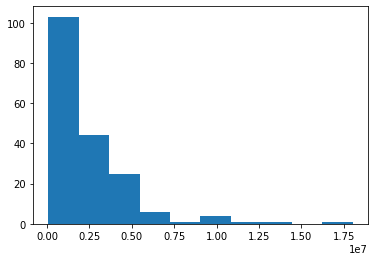

In [ ]:
plt.hist(np.array(shapes))

In [ ]:
max_file_size/min_file_size, min_file_size/3, 5457513.6/min_file_size

(248.32407407407408, 24192.0, 75.19722222222222)

### option 1: Using minimum sized file as the window size

In [ ]:
iterator = iter(train_ds)
sample, label = iterator.next()

In [ ]:
sample, label

(<tf.Tensor: shape=(1696896,), dtype=float32, numpy=
 array([0.00861943, 0.00861943, 0.00861943, ..., 0.00861943, 0.00861943,
        0.00861943], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [ ]:
#export
def pad_by_zeros(sample, min_file_size, last_sample_size):
    padding_size = min_file_size - last_sample_size
    sample_padded = tf.pad(sample, paddings=[[tf.constant(0), padding_size]])
    return sample_padded

In [ ]:
#export
def split_file_by_window_size(sample, label):
    # number of subsamples given none overlapping window size. 
    subsample_count = int(np.round(sample.shape[0]/min_file_size))
    # ignore extremely long files for now
    subsample_limit = 75
    if subsample_count <= subsample_limit:
        # if the last sample is at least half the window size, then pad it, if not, clip it.
        last_sample_size = sample.shape[0]%min_file_size
        if last_sample_size/min_file_size > 0.5:
            sample = pad_by_zeros(sample, min_file_size, last_sample_size)
        else:
            sample = sample[:subsample_count*min_file_size]
        sample = tf.reshape(sample, shape=[subsample_count, min_file_size])
        label = tf.pad(tf.expand_dims(label, axis=0), paddings=[[0, subsample_count-1]], constant_values=label.numpy())
    else:
        sample = tf.reshape(sample[:subsample_limit*min_file_size], shape=[subsample_limit, min_file_size])
        label = tf.pad(tf.expand_dims(label, axis=0), paddings=[[0, 74]], constant_values=label.numpy())
    return sample, label

In [ ]:
#export
def wrapper_split_file_by_window_size(sample, label):
    sample, label = tf.py_function(split_file_by_window_size, inp=(sample, label),
            Tout=(sample.dtype, label.dtype))
    return sample, label

In [ ]:
new_sample, new_label = split_file_by_window_size(sample, label)

In [ ]:
new_sample.shape, new_label.shape

(TensorShape([23, 72576]), TensorShape([23]))

In [ ]:
sample.shape, label.shape, sample.shape/min_file_size

(TensorShape([1696896]), TensorShape([]), array([23.38095238]))

In [ ]:
train_win_ds = train_ds.map(wrapper_split_file_by_window_size)
val_win_ds = val_ds.map(wrapper_split_file_by_window_size)
test_win_ds = test_ds.map(wrapper_split_file_by_window_size)

In [ ]:
#export
def create_dataset_fixed_size(ds):
    iterator = iter(ds)
    sample, label = iterator.next()
    samples_all = tf.unstack(sample)
    labels_all = tf.unstack(label)

    while True:
        try:
            sample, label = iterator.next()
            sample = tf.unstack(sample)
            label = tf.unstack(label)
            samples_all = tf.concat([samples_all, sample], axis=0)
            labels_all = tf.concat([labels_all, label], axis=0)
        except:
            break
    return samples_all, labels_all

In [ ]:
%%time
train_samples_all, train_labels_all = create_dataset_fixed_size(train_win_ds)

CPU times: user 1min 28s, sys: 1min 31s, total: 3min
Wall time: 1min 18s


In [ ]:
val_samples_all, val_labels_all = create_dataset_fixed_size(val_win_ds)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_samples_all, train_labels_all))
val_ds = tf.data.Dataset.from_tensor_slices((val_samples_all, val_samples_all))

In [ ]:
#export
def get_spectrogram(sample, label):
    spectrogram = tfio.experimental.audio.spectrogram(sample, nfft=512, window=512, stride=256)
    return spectrogram, label

In [ ]:
train_ds = train_ds.map(get_spectrogram)
val_ds = val_ds.map(get_spectrogram)

In [ ]:
iterator = iter(train_ds)

In [ ]:
a, b = next(iterator)

In [ ]:
a.shape

TensorShape([284, 257])

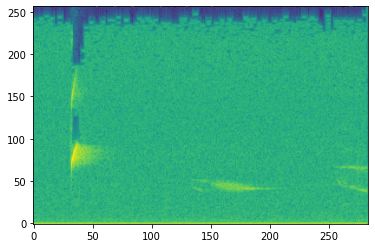

In [ ]:
data = tf.transpose(tf.math.log(a))
plt.imshow(data, aspect='auto', origin='lower')

In [ ]:
#export
def add_channel_dim(sample, label):
    sample = tf.expand_dims(sample, axis=-1)
    return sample, label

In [ ]:
train_ds = train_ds.map(add_channel_dim)
val_ds = val_ds.map(add_channel_dim)

### simple model

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers, losses, optimizers

In [ ]:
keras.backend.clear_session()

In [ ]:
model = tf.keras.Sequential([
            layers.Conv2D(filters=32, kernel_size=(4,4), strides=1, activation='relu', input_shape=(284, 257, 1)),
            layers.MaxPool2D(pool_size=(4,4)),
            layers.Conv2D(filters=64, kernel_size=(4,4), strides=1, activation='relu'),
            layers.MaxPool2D(pool_size=(4,4)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(3)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 281, 254, 32)      544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 60, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                983104    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [ ]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_ds = train_ds.shuffle(500, seed=seed).cache().prefetch(AUTOTUNE).batch(32)

In [ ]:
val_ds = val_ds.shuffle(500, seed=seed).cache().prefetch(AUTOTUNE).batch(32)

In [ ]:
#LargeDataset
model.fit(train_ds, epochs=2, validation_data=val_ds)